In [1]:
import os
import numpy as np
import pandas as pd
from joblib import dump, load
import sys
import seaborn as sns
import json
sys.path.append(os.path.join(os.path.abspath('../'), 'predictions_collapsed'))
sys.path.append(os.path.join(os.path.abspath('../'), 'src'))
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import torch
import skorch
import glob


from config_loader import (
    D_CONFIG,
    DATASET_SITE_PATH, DATASET_SPLIT_PATH,
    DATASET_FEAT_PER_TSLICE_PATH,
    PROJECT_REPO_DIR, PROJECT_CONDA_ENV_YAML,
    RESULTS_SPLIT_PATH, RESULTS_FEAT_PER_TSTEP_PATH)

sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src'))
sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src', 'rnn'))
from feature_transformation import *
from filter_admissions_by_tslice import get_preprocessed_data
from merge_features_all_tslices import merge_data_dicts, get_all_features_data
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             average_precision_score, confusion_matrix, log_loss,
                             roc_auc_score, roc_curve, precision_recall_curve)
from utils import load_data_dict_json
from dataset_loader import TidySequentialDataCSVLoader
from RNNBinaryClassifier import RNNBinaryClassifier
from sklearn.model_selection import GridSearchCV
RESULTS_FEAT_PER_TSTEP_PATH = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 'rnn')
CLF_TRAIN_TEST_SPLIT_PATH=os.path.join(DATASET_FEAT_PER_TSLICE_PATH, 'classifier_train_test_split')

In [2]:
RESULTS_FEAT_PER_TSTEP_PATH

'/tmp/results/madrid/v20200424/HIL/split-by=patient_id/features_per_timestep/rnn'

### Load x-train, ytrain and x-test, ytest

### Get the tstops_df for each patient-stay-slice

### Get 3 different train and test dataframes divided by slice

### Pass each of the 3 dataframes through dataset_loader and 3 different tensors

### Merge the 3 tensors into a single large tensor

In [3]:
x_train = pd.read_csv(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'x_train.csv'))
x_test = pd.read_csv(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'x_test.csv'))
y_train = pd.read_csv(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_train.csv'))
y_test = pd.read_csv(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.csv'))
x_data_dict = load_data_dict_json(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'x_dict.json'))
y_data_dict = load_data_dict_json(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_dict.json'))

In [4]:
def get_tslice_x_y(x, y, tstops_df, id_cols, time_col):
    '''Filters the full sequence by tslice'''
    x_curr_tslice = pd.merge(x, tstops_df, on=id_cols, how='inner')
    curr_slice_tinds = x_curr_tslice[time_col]<=x_curr_tslice['tstop']
    x_curr_tslice = x_curr_tslice.loc[curr_slice_tinds, :].copy()
    x_curr_tslice.drop(columns=['tstop'], inplace=True)
    y_curr_tslice = pd.merge(y, x_curr_tslice[id_cols], 
                                   on=id_cols, how='inner')
    
    return x_curr_tslice, y_curr_tslice

train_slices = ['90%', '30%']

max_T_train = 0
max_T_test = 0
id_cols = parse_id_cols(x_data_dict)
time_col = parse_time_col(x_data_dict)
feature_cols = parse_feature_cols(x_data_dict)
train_tensors_per_tslice_list = []
test_tensors_per_tslice_list = []
for ind, tslice in enumerate(train_slices):
    tstops_df = pd.read_csv(os.path.join(DATASET_FEAT_PER_TSLICE_PATH, 'TSLICE={tslice}', 
                                         'tstops_filtered_{tslice}_hours.csv').format(tslice=tslice))
    x_train_curr_tslice, y_train_curr_tslice = get_tslice_x_y(x_train, y_train, tstops_df, id_cols, time_col)
    x_test_curr_tslice, y_test_curr_tslice = get_tslice_x_y(x_test, y_test, tstops_df, id_cols, time_col)
    
    train_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_train_curr_tslice,
        y_csv_path=y_train_curr_tslice,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name='clinical_deterioration_outcome',
        y_label_type='per_sequence'
    )

    test_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_test_curr_tslice,
        y_csv_path=y_test_curr_tslice,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name='clinical_deterioration_outcome',
        y_label_type='per_sequence'
    )
    del x_train_curr_tslice, x_test_curr_tslice, y_train_curr_tslice, y_test_curr_tslice
    
    X_train_tensor_curr_tslice, y_train_tensor_curr_tslice = train_vitals.get_batch_data(batch_id=0)
    X_test_tensor_curr_tslice, y_test_tensor_curr_tslice = test_vitals.get_batch_data(batch_id=0)
    
    curr_T_train = X_train_tensor_curr_tslice.shape[1]
    curr_T_test = X_test_tensor_curr_tslice.shape[1]
    
    if curr_T_train>max_T_train:
        max_T_train = curr_T_train
        
    if curr_T_test>max_T_test:
        max_T_test = curr_T_test
        
    X_train_tensor_curr_tslice = np.pad(X_train_tensor_curr_tslice, 
                                        ((0,0), (0, max_T_train-curr_T_train), (0,0)), 'constant')
    X_test_tensor_curr_tslice = np.pad(X_test_tensor_curr_tslice, 
                                        ((0,0), (0, max_T_test-curr_T_test), (0,0)), 'constant')
    
    if ind==0:
        X_train_tensor = X_train_tensor_curr_tslice
        y_train_tensor = y_train_tensor_curr_tslice
        X_test_tensor = X_test_tensor_curr_tslice
        y_test_tensor = y_test_tensor_curr_tslice
    else:
        X_train_tensor = np.vstack((X_train_tensor, X_train_tensor_curr_tslice))
        y_train_tensor = np.hstack((y_train_tensor, y_train_tensor_curr_tslice))
        X_test_tensor = np.vstack((X_test_tensor, X_test_tensor_curr_tslice))
        y_test_tensor = np.hstack((y_test_tensor, y_test_tensor_curr_tslice))   
    
    del X_train_tensor_curr_tslice, X_test_tensor_curr_tslice
    
    
#     train_tensors_per_tslice_list.append([X_train_tensor_curr_tslice, y_train_tensor_curr_tslice])
#     test_tensors_per_tslice_list.append([X_test_tensor_curr_tslice, y_test_tensor_curr_tslice])

    

In [6]:
y_train_tensor.shape

(62717,)

In [34]:
T_list = []
final_N = 0
for i in train_tensors_per_tslice_list:
    N, T, F = i[0].shape
    T_list.append(T)
    final_N += N
max_T = max(T_list)


for i in range(len(train_tensors_per_tslice_list)):
    curr_x = train_tensors_per_tslice_list[i][0]
    curr_T = curr_x.shape[1]
    curr_x = np.pad(curr_x, ((0,0), (0, max_T-curr_T), (0,0)), 'constant')
    train_tensors_per_tslice_list[i][0] = curr_x 





TypeError: 'tuple' object does not support item assignment

In [33]:
x = train_tensors_per_tslice_list[0][0]
# x[:, 210:300,:]=0

# np.pad(x, ((0,0), (0,89), (0, 0)), 'constant').shape
train_tensors_per_tslice_list[0][0].shape

(31281, 211, 138)

## Evaluate RNN performance

- load the saved RNN models

- Get the test tslice data from all the folders

- Use dataset_loader and impute missing values to first impute and then load the padded sequences

- Test on sequences

In [ ]:
OUTCOME_COLUMN_NAME = 'clinical_deterioration_outcome'
evaluation_tslices = D_CONFIG['EVALUATE_TIMESLICE_LIST']

## get the test patient id's
# get the test set's csv and dict
y_test_df = pd.read_csv(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.csv'))
y_test_dict_file = os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_dict.json')

# import the y dict to get the id cols
y_test_dict = load_data_dict_json(y_test_dict_file)
id_cols = parse_id_cols(y_test_dict)

tslice_folders = os.path.join(DATASET_FEAT_PER_TSLICE_PATH, 'TSLICE=')
outcome_col_name = OUTCOME_COLUMN_NAME
tslices_list = evaluation_tslices
y_test_ids_df = y_test_df[id_cols].drop_duplicates(subset=id_cols).reset_index(drop=True)

# get demographics csv and data_dict
# for each patient get their vitals, labs, demographics
_,labs_data_dict,_,vitals_data_dict, _, demographics_data_dict,_,_ = get_preprocessed_data(DATASET_SITE_PATH)
time_col = parse_time_col(vitals_data_dict)

# prctile_vals = [5, 50, 95]
# random_seed_list = args.random_seed_list.split(' ')
# perf_df = pd.DataFrame()

# load classifier
rnn = RNNBinaryClassifier(module__rnn_type='LSTM',
                      module__n_layers=1,
                      module__n_hiddens=128,
                      module__n_inputs=X_test.shape[-1])
rnn.initialize()
rnn.load_params(f_params=os.path.join(RESULTS_FEAT_PER_TSTEP_PATH,
                                  'hiddens=128-layers=1-lr=0.0025-dropout=0-weight_decay=0.0001params.pt'),
            f_optimizer=os.path.join(RESULTS_FEAT_PER_TSTEP_PATH,
                                     'hiddens=128-layers=1-lr=0.0025-dropout=0-weight_decay=0.0001optimizer.pt'),
            f_history=os.path.join(RESULTS_FEAT_PER_TSTEP_PATH,
                                   'hiddens=128-layers=1-lr=0.0025-dropout=0-weight_decay=0.0001history.json'))

# predict on each tslice
for p, tslice in enumerate(tslices_list):
    tslice_folder = tslice_folders + tslice
    # get test set labs and vitals
    vitals_df = pd.read_csv(os.path.join(tslice_folder, 'vitals_before_icu_filtered_%s_hours.csv'%tslice))
    labs_df = pd.read_csv(os.path.join(tslice_folder, 'labs_before_icu_filtered_%s_hours.csv'%tslice))
    demographics_df = pd.read_csv(os.path.join(tslice_folder, 'demographics_before_icu_filtered_%s_hours.csv'%tslice))
    outcomes_df = pd.read_csv(os.path.join(tslice_folder,
                                           'clinical_deterioration_outcomes_filtered_%s_hours.csv'%tslice))
    test_vitals_df = pd.merge(vitals_df, y_test_ids_df, on=id_cols)
    test_labs_df = pd.merge(labs_df, y_test_ids_df, on=id_cols)
    test_demographics_df = pd.merge(demographics_df, y_test_ids_df, on=id_cols)

    # merge the labs, vitals and demographics to get a single features table
    test_features_df,test_features_dict = get_all_features_data(test_labs_df, labs_data_dict, 
                                                        test_vitals_df, vitals_data_dict, 
                                                        test_demographics_df, demographics_data_dict)


    test_outcomes_df = pd.merge(outcomes_df, y_test_ids_df, on=id_cols, how='inner')
    
    test_features_df.sort_values(by=id_cols+[time_col], inplace=True)
    test_outcomes_df.sort_values(by=id_cols, inplace=True)
    
    # impute missing values in the test features
    test_features_df = test_features_df.groupby(id_cols).apply(lambda x: x.fillna(method='pad')).copy()
    feature_cols = parse_feature_cols(test_features_dict)
    
    for feature_col in feature_cols:
        test_features_df[feature_col].fillna(test_features_df[feature_col].mean(), inplace=True)    
    
    # load test data with TidySequentialDataLoader
    test_vitals = TidySequentialDataCSVLoader(
        x_csv_path=test_features_df,
        y_csv_path=test_outcomes_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name=outcome_col_name,
        y_label_type='per_sequence'
    )    
    
    # load the classifier
    X_test, y_test = test_vitals.get_batch_data(batch_id=0)
    y_pred_proba = rnn.predict_proba(X_test)
    y_pred_proba_neg, y_pred_proba_pos = zip(*y_pred_proba)
    auroc_test_final = roc_auc_score(y_test, y_pred_proba_pos)
    print('tslice: %s, auroc_test : %.2f'%(tslice, auroc_test_final))
    
    
    
   


## Plot loss curves

## 32 hiddens

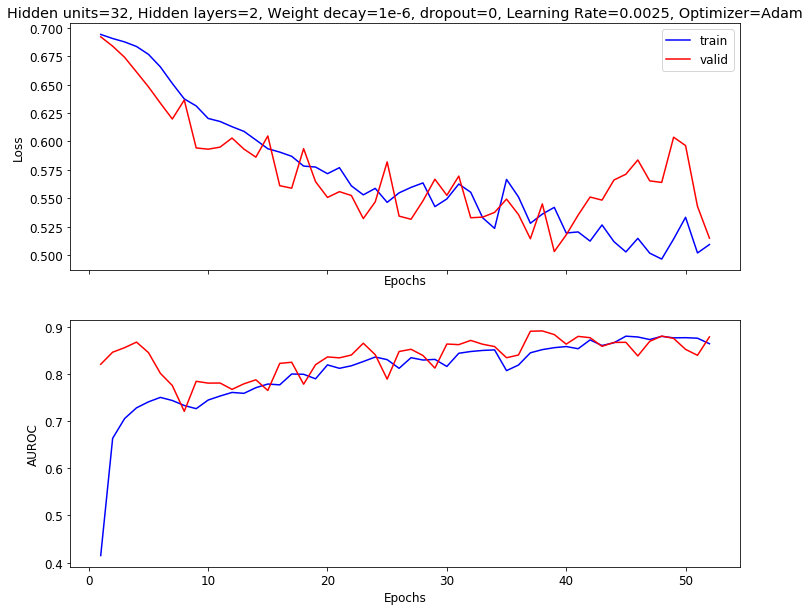

In [4]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=32-layers=2-lr=0.0025-dropout=0-weight_decay=1e-06.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=32, Hidden layers=2, Weight decay=1e-6, dropout=0, Learning Rate=0.0025, Optimizer=Adam, clipping=0.1')
plt.show()


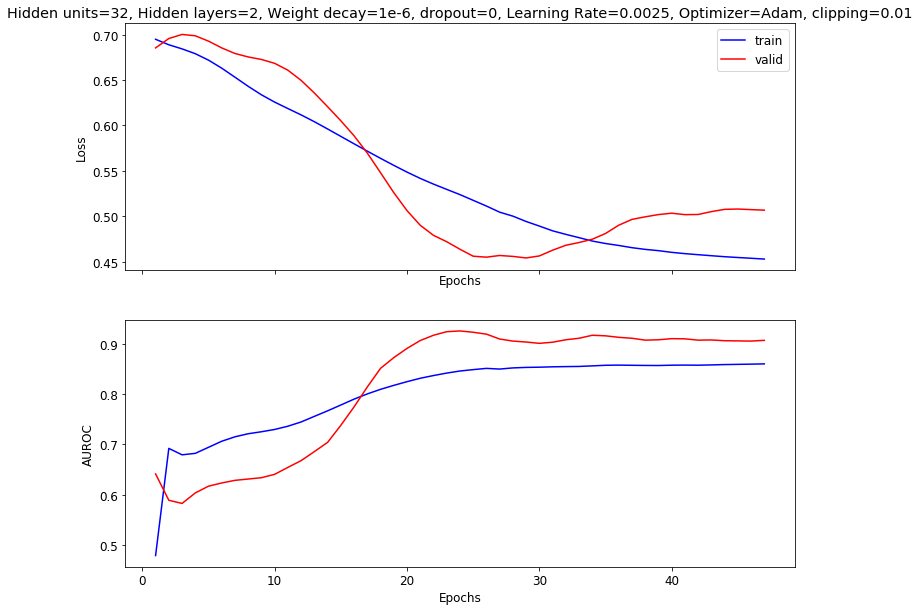

In [18]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=32-layers=2-lr=0.0025-dropout=0-weight_decay=1e-06.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=32, Hidden layers=2, Weight decay=1e-6, dropout=0, Learning Rate=0.0025, Optimizer=Adam, clipping=0.01')
plt.show()

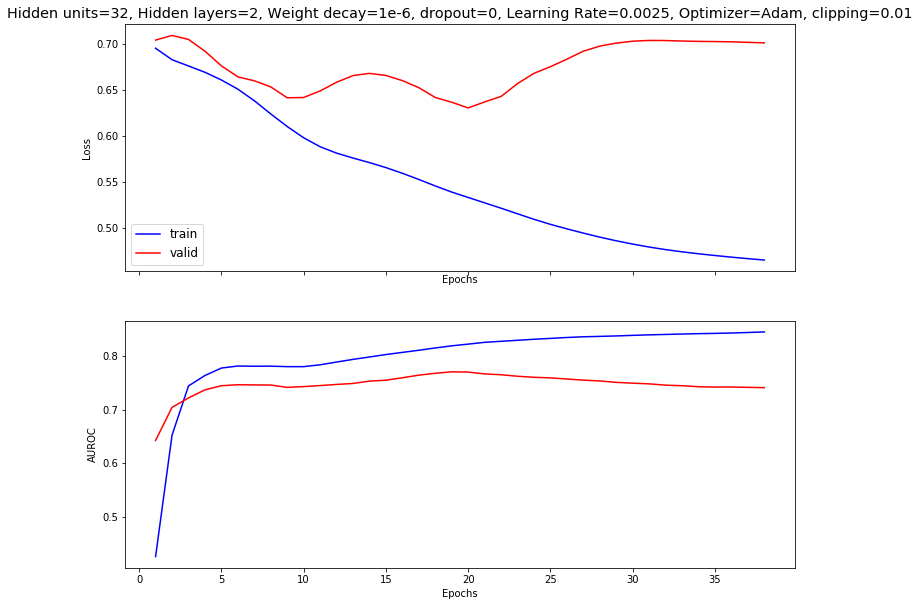

In [3]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=32-layers=2-lr=0.0025-dropout=0-weight_decay=1e-06.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=32, Hidden layers=2, Weight decay=1e-6, dropout=0, Learning Rate=0.0025, Optimizer=Adam, clipping=0.01')
plt.show()

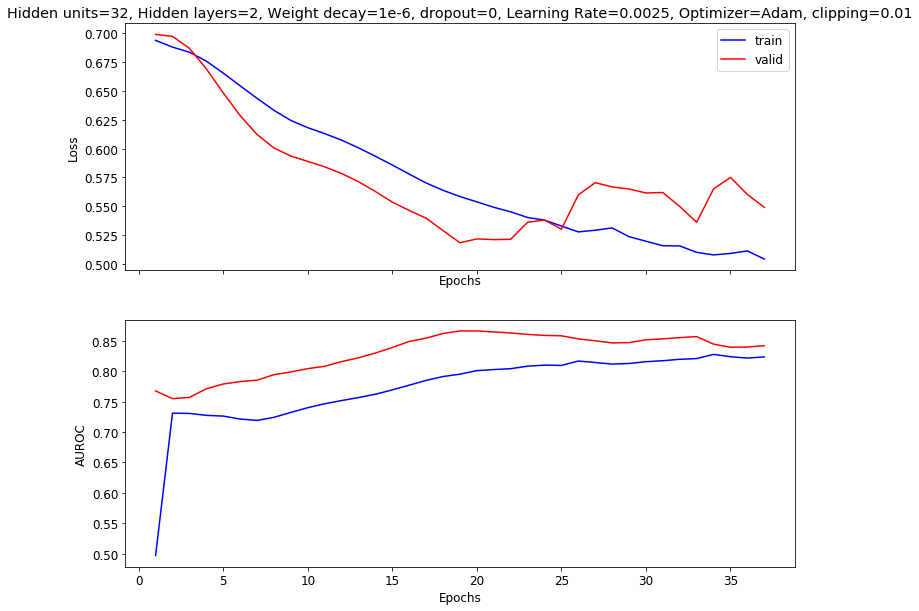

In [4]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=32-layers=2-lr=0.0025-dropout=0-weight_decay=1e-06.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=32, Hidden layers=2, Weight decay=1e-6, dropout=0, Learning Rate=0.0025, Optimizer=Adam, clipping=0.01')
plt.show()

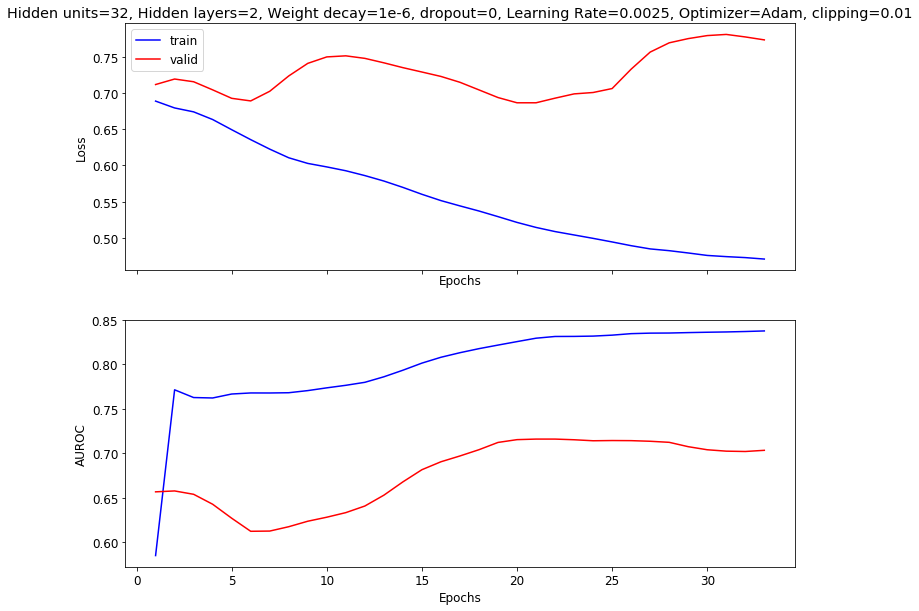

In [5]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=32-layers=2-lr=0.0025-dropout=0-weight_decay=1e-06.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=32, Hidden layers=2, Weight decay=1e-6, dropout=0, Learning Rate=0.0025, Optimizer=Adam, clipping=0.01')
plt.show()

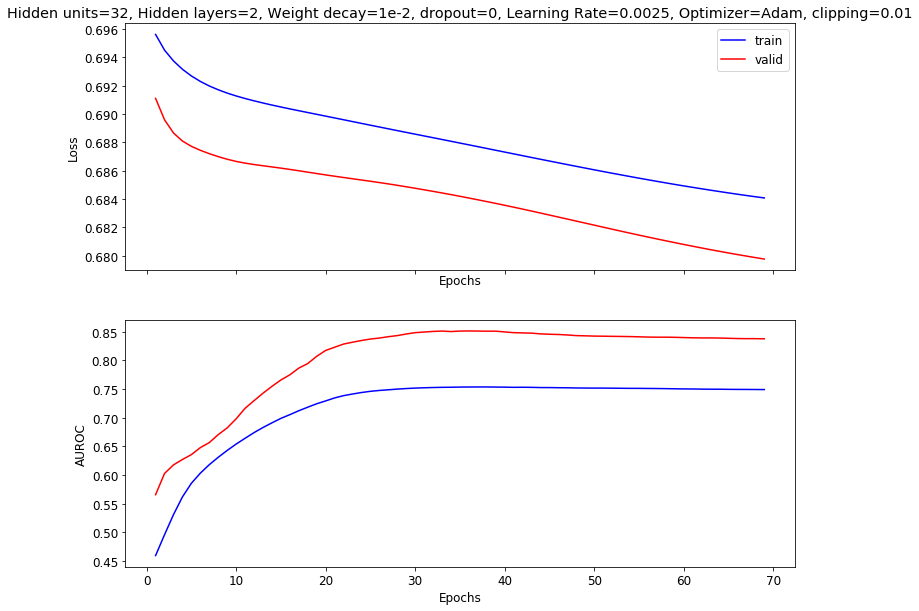

In [6]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=32-layers=2-lr=0.0025-dropout=0-weight_decay=1e-06.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=32, Hidden layers=2, Weight decay=1e-2, dropout=0, Learning Rate=0.0025, Optimizer=Adam, clipping=0.01')
plt.show()

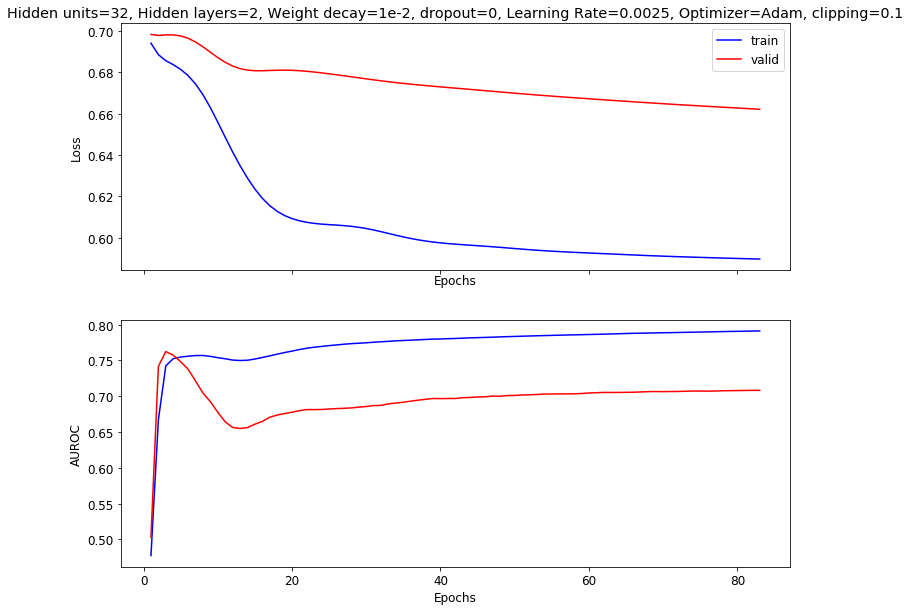

In [8]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=32-layers=2-lr=0.0025-dropout=0-weight_decay=1e-06.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=32, Hidden layers=2, Weight decay=1e-2, dropout=0, Learning Rate=0.0025, Optimizer=Adam, clipping=0.1')
plt.show()

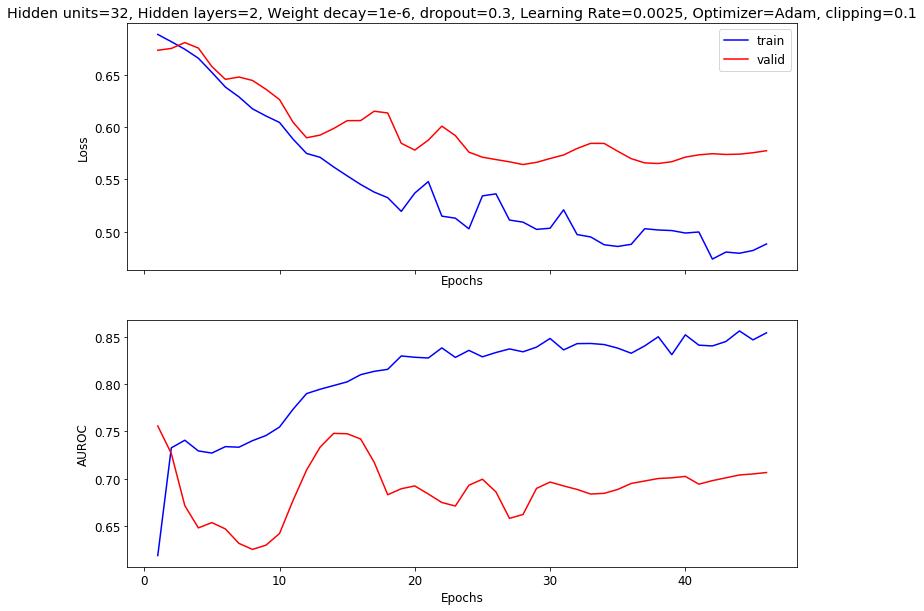

In [10]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=32-layers=2-lr=0.0025-dropout=0-weight_decay=1e-06.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=32, Hidden layers=2, Weight decay=1e-6, dropout=0.3, Learning Rate=0.0025, Optimizer=Adam, clipping=0.1')
plt.show()

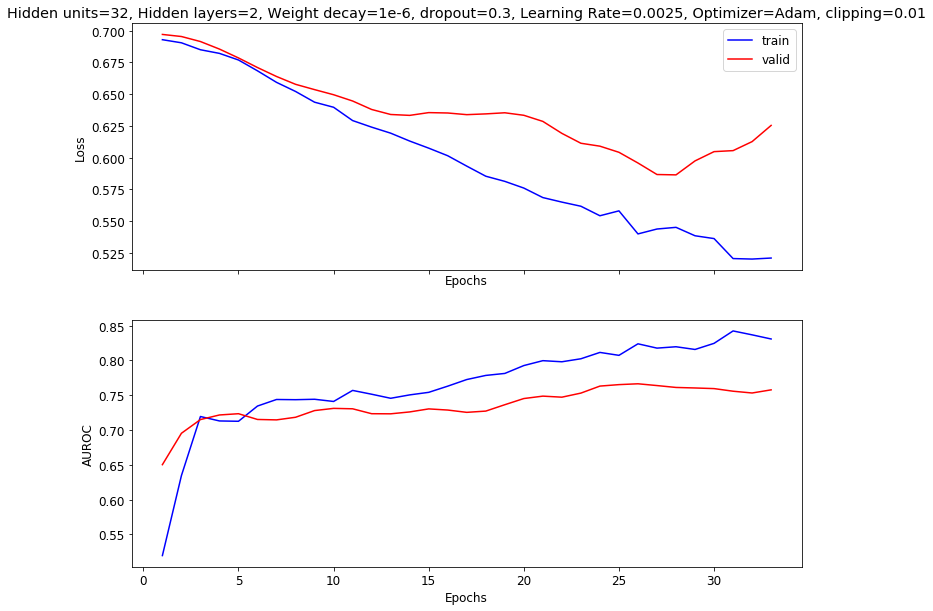

In [13]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=32-layers=2-lr=0.0025-dropout=0-weight_decay=1e-06.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=32, Hidden layers=2, Weight decay=1e-6, dropout=0.3, Learning Rate=0.0025, Optimizer=Adam, clipping=0.01')
plt.show()

## 64 hiddens

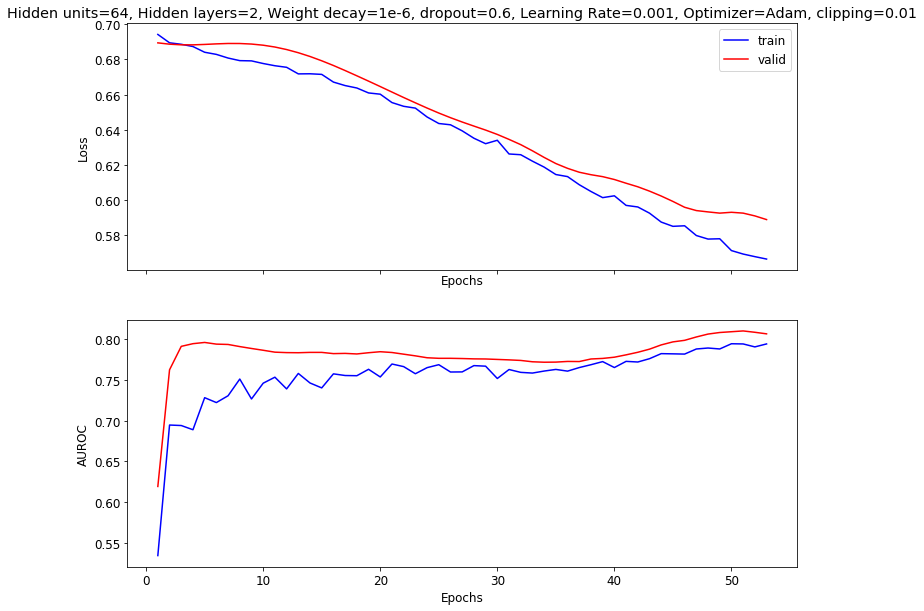

In [5]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=64-layers=2-lr=0.001-dropout=0.6-weight_decay=1e-06.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=64, Hidden layers=2, Weight decay=1e-6, dropout=0.6, Learning Rate=0.001, Optimizer=Adam, clipping=0.01')
plt.show()

## Full dataset trained models

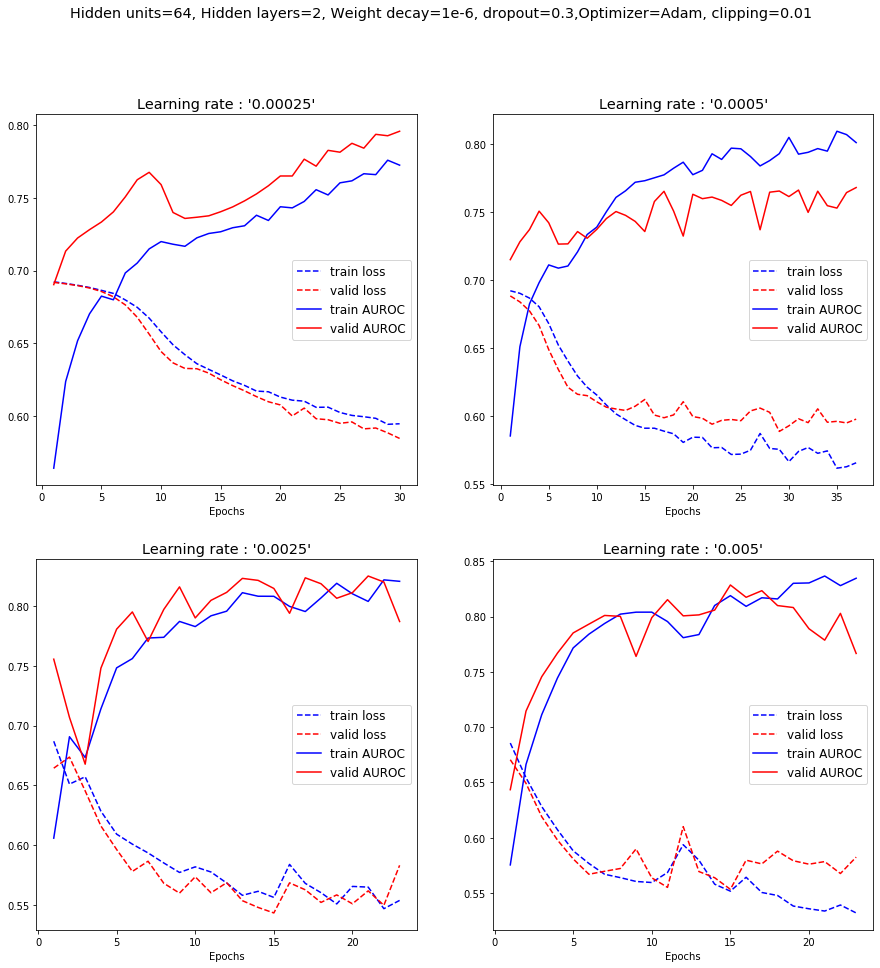

In [2]:
f, axs= plt.subplots(2,2, figsize=(15,15))

axs_list = axs.flatten()
for i, lr in enumerate(['0.00025', '0.0005', '0.0025', '0.005']):

    rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                             'hiddens=64-layers=2-lr=%s-dropout=0.3-weight_decay=1e-06.json'%lr)


    with open(rnn_hist_json, 'r') as f:
        rnn_dict = json.load(f)
    epochs=[i['epoch'] for i in rnn_dict[:-1]]
    train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
    valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
    aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
    aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

#     f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
    plt.rcParams.update({'font.size': 12})
    axs_list[i].plot(epochs, train_loss, 'b--', label='train loss')
    axs_list[i].plot(epochs, valid_loss, 'r--', label='valid loss')
    axs_list[i].set_xlabel('Epochs')
#     axs_list[i].set_ylabel('Loss')
    axs_list[i].plot(epochs, aucroc_score_train, 'b', label='train AUROC')
    axs_list[i].plot(epochs, aucroc_score_valid, 'r', label='valid AUROC')
    axs_list[i].set_xlabel('Epochs')
    axs_list[i].legend()
    axs_list[i].set_title('Learning rate : %lr'%lr)

plt.suptitle('Hidden units=64, Hidden layers=2, Weight decay=1e-6, dropout=0.3,Optimizer=Adam, clipping=0.01')
plt.show()

## Datasets trained with multiple random seed intializations

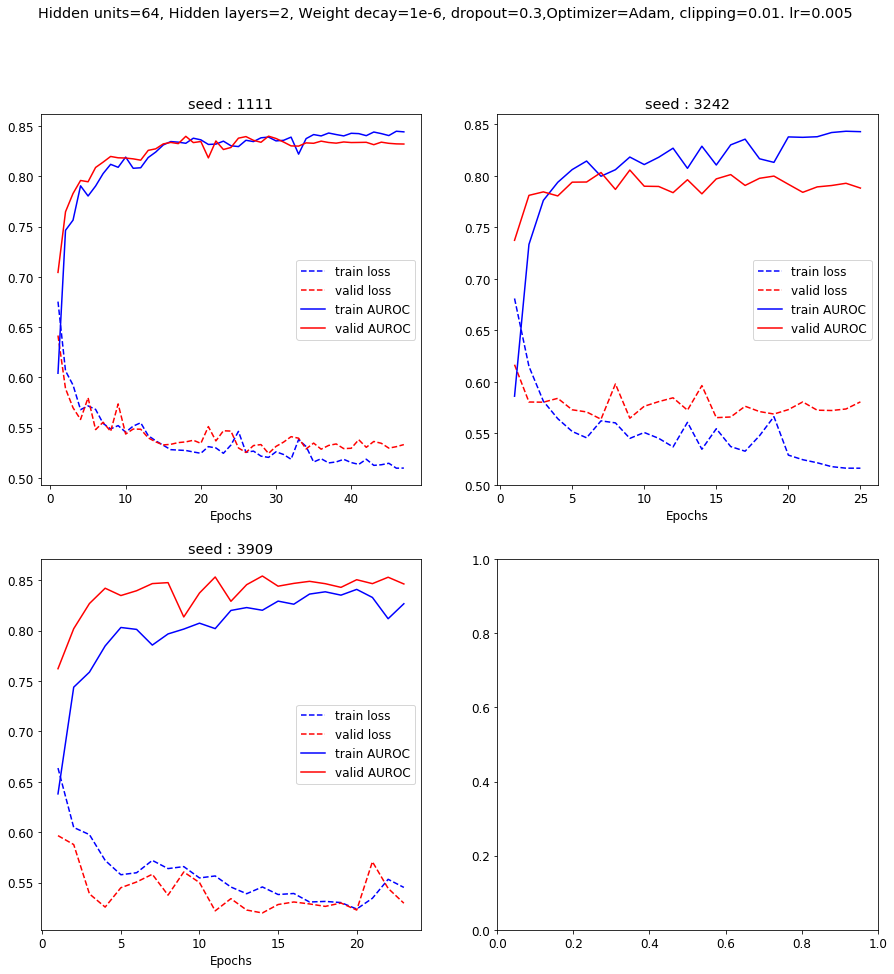

In [3]:
f, axs= plt.subplots(2,2, figsize=(15,15))

axs_list = axs.flatten()
for j, seed in enumerate(['1111', '3242', '3909']):

    rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                             'hiddens=128-layers=2-lr=0.005-dropout=0.3-weight_decay=1e-06-seed=%s.json'%seed)


    with open(rnn_hist_json, 'r') as f:
        rnn_dict = json.load(f)
    epochs=[i['epoch'] for i in rnn_dict[:-1]]
    train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
    valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
    aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
    aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

#     f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
    plt.rcParams.update({'font.size': 12})
    axs_list[j].plot(epochs, train_loss, 'b--', label='train loss')
    axs_list[j].plot(epochs, valid_loss, 'r--', label='valid loss')
    axs_list[j].set_xlabel('Epochs')
#     axs_list[i].set_ylabel('Loss')
    axs_list[j].plot(epochs, aucroc_score_train, 'b', label='train AUROC')
    axs_list[j].plot(epochs, aucroc_score_valid, 'r', label='valid AUROC')
    axs_list[j].set_xlabel('Epochs')
    axs_list[j].legend()
    axs_list[j].set_title('seed : %s'%seed)

plt.suptitle('Hidden units=64, Hidden layers=2, Weight decay=1e-6, dropout=0.3,Optimizer=Adam, clipping=0.01. lr=0.005')
plt.show()

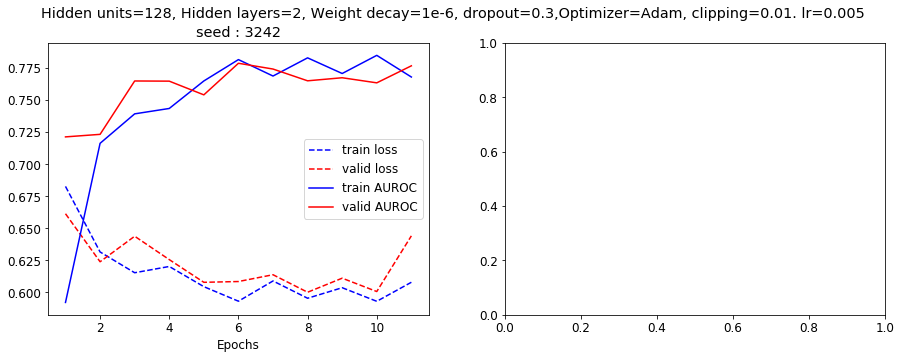

In [10]:
f, axs= plt.subplots(1,2, figsize=(15,5))

axs_list = axs.flatten()
for j, seed in enumerate(['3242']):

    rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH,
                             'hiddens=128-layers=2-lr=0.005-dropout=0.3-weight_decay=1e-06-seed=%s.json'%seed)


    with open(rnn_hist_json, 'r') as f:
        rnn_dict = json.load(f)
    epochs=[i['epoch'] for i in rnn_dict[:-1]]
    train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
    valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
    aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
    aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

#     f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
    plt.rcParams.update({'font.size': 12})
    axs_list[j].plot(epochs, train_loss, 'b--', label='train loss')
    axs_list[j].plot(epochs, valid_loss, 'r--', label='valid loss')
    axs_list[j].set_xlabel('Epochs')
#     axs_list[i].set_ylabel('Loss')
    axs_list[j].plot(epochs, aucroc_score_train, 'b', label='train AUROC')
    axs_list[j].plot(epochs, aucroc_score_valid, 'r', label='valid AUROC')
    axs_list[j].set_xlabel('Epochs')
    axs_list[j].legend()
    axs_list[j].set_title('seed : %s'%seed)

plt.suptitle('Hidden units=128, Hidden layers=2, Weight decay=1e-6, dropout=0.3,Optimizer=Adam, clipping=0.01. lr=0.005')
plt.show()

## 200 units

In [ ]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=200-layers=2-lr=0.0001-dropout=0.1-weight_decay=1e-06-seed=1111.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=200, Hidden layers=2, Weight decay=1e-6, dropout=0.1, Learning Rate=0.0001, Optimizer=Adam')
plt.show()

# HIL

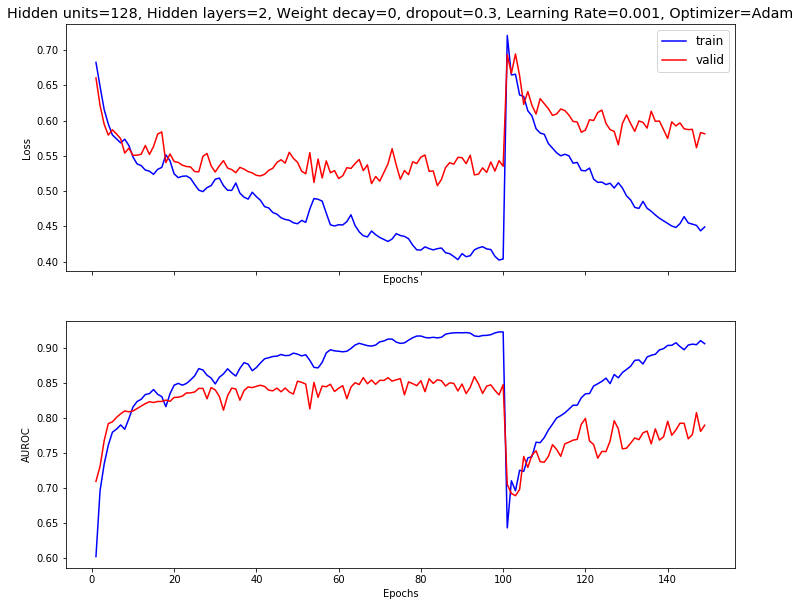

In [3]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=128-layers=2-lr=0.001-dropout=0.3-weight_decay=0-seed=1111.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=128, Hidden layers=2, Weight decay=0, dropout=0.3, Learning Rate=0.001, Optimizer=Adam')
plt.show()

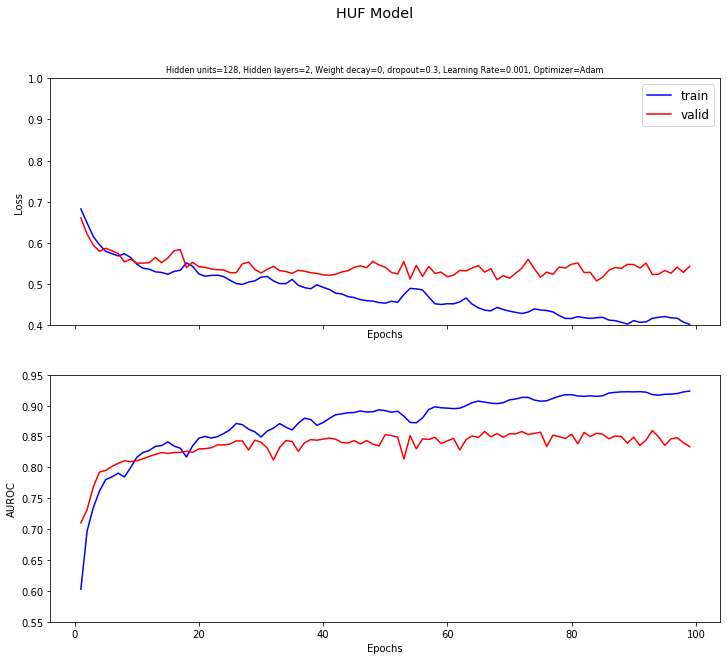

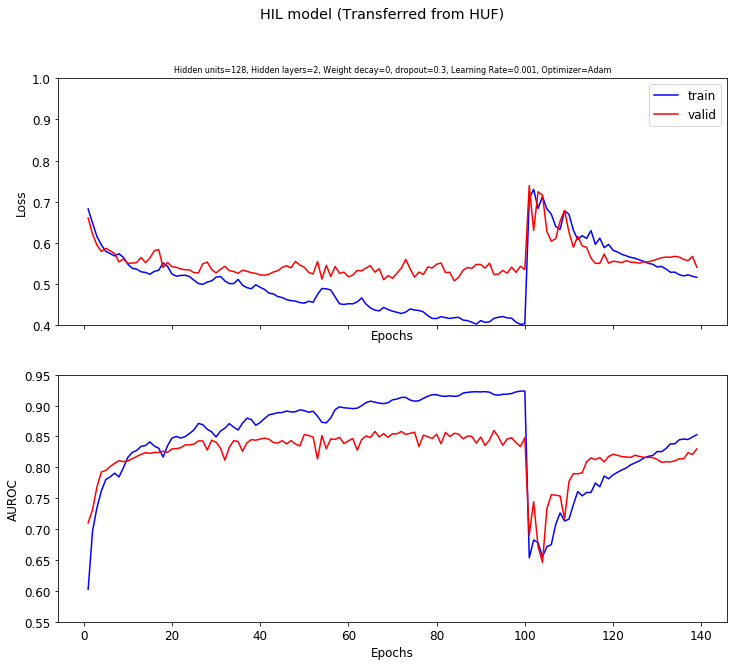

In [3]:
hil_model_dir = '/tmp/results/madrid/v20200424/HIL/split-by=patient_id/features_per_timestep/rnn/'
huf_model_dir = '/tmp/results/madrid/v20200424/HUF/split-by=patient_id/features_per_timestep/rnn/current_best_model'

model_dirs = [huf_model_dir, hil_model_dir]
model_names = ['HUF Model', 'HIL model (Transferred from HUF)']
for model_ind, model_dir in enumerate(model_dirs):
    rnn_hist_json = os.path.join(model_dir, 
                             'hiddens=128-layers=2-lr=0.001-dropout=0.3-weight_decay=0-seed=1111.json')


    with open(rnn_hist_json, 'r') as f:
        rnn_dict = json.load(f)
    epochs=[i['epoch'] for i in rnn_dict[:-1]]
    train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
    valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
    aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
    aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

    f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
    plt.rcParams.update({'font.size': 12})
    axs[0].plot(epochs, train_loss, 'b', label='train')
    axs[0].plot(epochs, valid_loss, 'r', label='valid')
    axs[0].set_ylim([0.4, 1])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(epochs, aucroc_score_train, 'b')
    axs[1].plot(epochs, aucroc_score_valid, 'r')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('AUROC')
    axs[1].set_ylim([0.55, 0.95])
    axs[0].set_title('Hidden units=128, Hidden layers=2, Weight decay=0, dropout=0.3, Learning Rate=0.001, Optimizer=Adam',
                    fontsize=8)
    plt.suptitle(model_names[model_ind])
    f.savefig('%s loss plots'%model_names[model_ind])
    plt.show()
